# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step -](#step-): Set up environment and utils
* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm
* [Step 7](#step7): Create a Flask app

---
<a id='step-'></a>
## Step -: Set up environment and utils

In [1]:
import torch

# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [2]:
from IPython.core.display import HTML, display
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import inspect

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def display_code(instance):
    display(HTML("""<style>{}</style>""".format(HtmlFormatter().get_style_defs('.highlight'))))
    display(HTML(data=highlight(inspect.getsource(instance), PythonLexer(), HtmlFormatter())))

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [5]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


---
<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


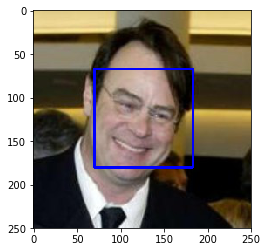

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path

from predict import face_detector
display_code(face_detector)

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [8]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def detected_tag(filelist, detector):
    correct = 0
    for file in filelist:
        if detector(file):
            correct += 1
            
    return correct

In [9]:
def log_detected(filelist, list_description, detector, det_description):
    print("{}% of {} {} files have at least a detected {}."\
      .format((detected_tag(filelist, detector)/len(filelist))*100, len(filelist), list_description, det_description))

In [10]:
log_detected(human_files_short, 'human', face_detector, 'human face')
log_detected(dog_files_short, 'dog', face_detector, 'human face')

98.0% of 100 human files have at least a detected human face.
18.0% of 100 dog files have at least a detected human face.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [12]:
# The code was moved to predict.py

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
from predict import VGG16_predict
display_code(VGG16_predict)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path

from predict import dog_detector
display_code(dog_detector)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [15]:
# ### TODO: Test the performance of the dog_detector function
# ### on the images in human_files_short and dog_files_short.

log_detected(human_files_short, 'human', dog_detector, 'dog')
log_detected(dog_files_short, 'dog', dog_detector, 'dog')

0.0% of 100 human files have at least a detected dog.
100.0% of 100 dog files have at least a detected dog.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [16]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | -
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
import os
from torchvision import datasets
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

from utils import get_transform
display_code(get_transform)


def img_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f).convert('RGB')
   
    return img
      
        
def get_loader(mode='train',
               norm=True,
               dataset='Dogs',
               batch_size=1,
               num_workers=0):
    dataset =  datasets.ImageFolder(
        '/data/dog_images/{}/'.format(mode),
        transform=get_transform(mode=mode, norm=norm, dataset=dataset),
        loader=img_loader)
    
    shuffle = False
    if mode == 'train':
        shuffle = True
        
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers)
        
    return data_loader

In [18]:
# Verify Dogs dataset normalization
if False:
    loader = get_loader(norm=False)
    mean = []
    std = []

    for c in range(3):
        means = []
        stds = []
        for i in range(4096):
            img, label = next(iter(loader))
            means.append(torch.mean(img[0][c]))
            stds.append(torch.std(img[0][c]))

        mean.append(torch.mean(torch.tensor(means)))
        std.append(torch.mean(torch.tensor(stds)))

    print(mean)  # [tensor(0.4868), tensor(0.4593), tensor(0.3936)]
    print(std)  # [tensor(0.2289), tensor(0.2259), tensor(0.2239)]

In [19]:
batch_size = 16
loaders_scratch = {
    'train' : get_loader(batch_size=batch_size),
    'valid' : get_loader(mode='valid', batch_size=batch_size),
    'test' : get_loader(mode='test')
}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
* The code does an initial resize to a 256 pixel smaller edge image from which a 244 pixel-per-side input square image is extracted. The final size value matches that of the pre-trained PyTorch models to put the focus on the comparison between network architectures on the inputs except for normalization.
* The square extraction already augments the data by random crop on top of which random rotations and random horizontal flips are applied during training. This is important because of the limited size of the dataset, but given the small number of training epochs, it is not as crucial as when training for 10+ epochs.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [20]:
# define the CNN architecture

from model import Net
display_code(Net)

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ The network has three convolutional layers followed by two linear layers, including the output layer. Convolutions are used for learning feature extraction kernels; therefore, with several of these layers acting on different sized inputs, the network will learn to distinguish between features available at multiple scales. Usually, the deeper the convolutional layer is the smaller the size of the input layer and the higher the number of filters in the kernel. Because the distinguishing features of fine-grained computer vision problems show at micro-level, in this case, the first two convolutional layers have the same number of kernels. Pooling and strides are used for encoding the inputs. Xavier weight initialization and batch normalization are used for faster convergence. The size of the first linear layer ensures the network has enough capacity for combining the features extracted by the convolutional layers. The dropout of the first linear layer tries to mitigate the risk of overfitting. The standard ReLU function is used for activations. The output layer size matches the number of classes in the dataset.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [21]:
### TODO: select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()

if use_cuda:
    criterion_scratch.cuda()

### TODO: select optimizer
optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=0.001, amsgrad=True)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [22]:
from time import time, sleep
from workspace_utils import active_session

In [23]:
def plot_losses(loss_train, loss_valid, filename='default.png'):
    """Plot the loss."""
    plt.plot([i+1 for i in range(len(loss_train))], loss_train, label='train', color='navy', lw=2, linestyle='--')
    
    if len(loss_valid) > 1:
        idx_multiplier = int(len(loss_train)/len(loss_valid))
        plt.plot([(i+1) * idx_multiplier for i in range(len(loss_valid))], loss_valid, label='valid', color='darkorange', lw=2, linestyle='--')
        
    plt.ylim([0.00, 10.0])
    plt.xlabel('Batch iteration')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.savefig(filename, dpi=300)
    plt.show()

In [24]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_loss_track = []
    valid_loss_track = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
   
            train_loss += loss.item()
            periodicity = 50
            if batch_idx % periodicity == 0:    # print every X batches
                train_loss_track.append(train_loss/(batch_idx + 1))
                log = 'Epoch: {:3d}, Batch: {:3d}, Avg. Loss: {:.6f}'\
                    .format(epoch, batch_idx, train_loss_track[-1])
                print(log)
            
        ######################
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            valid_loss += criterion(output, target).item()
        
        valid_loss_track.append(valid_loss/len(loaders['valid']))
            
            
        # print training/validation statistics 
        print('Epoch: {:3d}, Training Loss: {:.6f}, Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss_track[-1],
            valid_loss_track[-1]
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss_track[-1] < valid_loss_min:
            valid_loss_min = valid_loss_track[-1]
            print('\nSaving model after epoch {} at {}.'.format(epoch, save_path))
            torch.save(model.state_dict(), save_path)
        
    # plot loss
    print("")
    print("Train loss: {}".format(train_loss_track))
    print("Valid loss: {}".format(valid_loss_track))
    plot_losses(train_loss_track, valid_loss_track, "{}.png".format(save_path[:-3]))
            
    # return trained model
    return model

Epoch:   1, Batch:   0, Avg. Loss: 4.989769
Epoch:   1, Batch:  50, Avg. Loss: 5.217612
Epoch:   1, Batch: 100, Avg. Loss: 5.057402
Epoch:   1, Batch: 150, Avg. Loss: 4.949546
Epoch:   1, Batch: 200, Avg. Loss: 4.901672
Epoch:   1, Batch: 250, Avg. Loss: 4.849064
Epoch:   1, Batch: 300, Avg. Loss: 4.811994
Epoch:   1, Batch: 350, Avg. Loss: 4.782110
Epoch:   1, Batch: 400, Avg. Loss: 4.745753
Epoch:   1, Training Loss: 4.745753, Validation Loss: 4.341530

Saving model after epoch 1 at model_scratch.pt.
Epoch:   2, Batch:   0, Avg. Loss: 4.380348
Epoch:   2, Batch:  50, Avg. Loss: 4.342890
Epoch:   2, Batch: 100, Avg. Loss: 4.341020
Epoch:   2, Batch: 150, Avg. Loss: 4.345202
Epoch:   2, Batch: 200, Avg. Loss: 4.335995
Epoch:   2, Batch: 250, Avg. Loss: 4.354508
Epoch:   2, Batch: 300, Avg. Loss: 4.356774
Epoch:   2, Batch: 350, Avg. Loss: 4.342360
Epoch:   2, Batch: 400, Avg. Loss: 4.339102
Epoch:   2, Training Loss: 4.339102, Validation Loss: 4.050354

Saving model after epoch 2 at mo

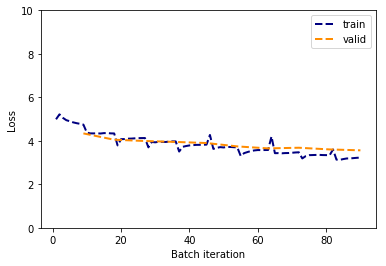

Training time: 1268.6 seconds.


In [25]:
if not use_cuda:
    map_location = "cpu"
else:
    map_location = "cuda"

train_state = True
start_from_checkpoint = False
epochs = 10
if train_state:
    if start_from_checkpoint:
        # load the model to continue training
        model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=map_location))

    # train the model
    t0 = time()
    with active_session():
        model_scratch = train(epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, 'model_scratch.pt')

    print("Training time: {:.1f} seconds.".format(time()-t0))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=map_location))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [26]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [27]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.533000
Test Accuracy: 18% (156/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [28]:
## TODO: Specify data loaders
dataset = 'ImageNet'
batch_size = 16
loaders_transfer = {
    'train' : get_loader(dataset=dataset, batch_size=batch_size),
    'valid' : get_loader(mode='valid', dataset=dataset, batch_size=batch_size),
    'test' : get_loader(mode='test', dataset=dataset)
}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [29]:
## TODO: Specify model architecture

from model import Net2
display_code(Net2)
    
model_transfer = Net2()

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The pre-trained ResNet-50 model is a convolution-based very-deep residual network with state-of-the-art results in computer vision tasks. Recent application using transfer learning show that such a pre-trained network can be used as a feature extractor for other computer vision problems, using the learned weights from one dataset to solve a different problem (classification or regression) on an unrelated dataset. To speed up training the weights of the pre-trained network are kept fixed. To linear layers following the pre-trained model are the same as for the ones following the convolutions of the sketch model to allow performance comparison on the convolutional layers.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [30]:
criterion_transfer = torch.nn.CrossEntropyLoss()

if use_cuda:
    criterion_transfer.cuda()

params = list(model_transfer.fc1.parameters()) + list(model_transfer.output.parameters())
optimizer_transfer = torch.optim.Adam(params, lr=0.001, amsgrad=True)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

Epoch:   1, Batch:   0, Avg. Loss: 4.907166
Epoch:   1, Batch:  50, Avg. Loss: 3.695851
Epoch:   1, Batch: 100, Avg. Loss: 2.794264
Epoch:   1, Batch: 150, Avg. Loss: 2.353220
Epoch:   1, Batch: 200, Avg. Loss: 2.077620
Epoch:   1, Batch: 250, Avg. Loss: 1.884722
Epoch:   1, Batch: 300, Avg. Loss: 1.760091
Epoch:   1, Batch: 350, Avg. Loss: 1.657285
Epoch:   1, Batch: 400, Avg. Loss: 1.580150
Epoch:   1, Training Loss: 1.580150, Validation Loss: 0.689387

Saving model after epoch 1 at model_transfer.pt.
Epoch:   2, Batch:   0, Avg. Loss: 1.094100
Epoch:   2, Batch:  50, Avg. Loss: 0.829981
Epoch:   2, Batch: 100, Avg. Loss: 0.833754
Epoch:   2, Batch: 150, Avg. Loss: 0.836424
Epoch:   2, Batch: 200, Avg. Loss: 0.818062
Epoch:   2, Batch: 250, Avg. Loss: 0.834942
Epoch:   2, Batch: 300, Avg. Loss: 0.829567
Epoch:   2, Batch: 350, Avg. Loss: 0.836387
Epoch:   2, Batch: 400, Avg. Loss: 0.835206
Epoch:   2, Training Loss: 0.835206, Validation Loss: 0.516590

Saving model after epoch 2 at m

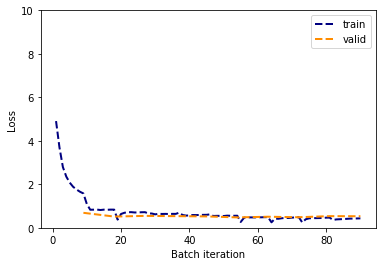

Training time: 1513.2 seconds.


In [31]:
if not use_cuda:
    map_location = "cpu"
else:
    map_location = "cuda"

train_state = True
start_from_checkpoint = False
epochs = 10
if train_state:
    if start_from_checkpoint:
        # load the model to continue training
        model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location))

    # train the model
    t0 = time()
    with active_session():
        model_transfer = train(epochs, loaders_transfer, model_transfer,
                               optimizer_transfer, criterion_transfer,
                               use_cuda, 'model_transfer.pt')

    print("Training time: {:.1f} seconds.".format(time()-t0))

    # load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.548539
Test Accuracy: 83% (694/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [33]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

data_transfer = {}
data_transfer['train'] = datasets.ImageFolder(
    '/data/dog_images/{}/'.format('train'),
    transform=get_transform(mode='train'),
    loader=img_loader)

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
with open("dog_classes.txt", "w") as f:
    for name in class_names:
        f.write("{}\n".format(name))

print(class_names)

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie',

In [34]:
from utils import transform_image
from predict import get_prediction
display_code(transform_image)
display_code(get_prediction)


def predict_breed_transfer(img_path, roi=None):
    # load the image and return the predicted breed
    if roi is None:
        with open(img_path, 'rb') as f:
            image_bytes = f.read()
            
    else:
        image_bytes = roi
        
    return get_prediction(image_bytes=image_bytes)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [35]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    faces = face_detector(img_path, box=True)
    dog = dog_detector(img_path)
    
    print("\n\nChecking input ...")
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
     
    if len(faces) > 0:
        for i, (x, y, w, h) in enumerate(faces):
            zoom_out_factor=.3
            h_factor = int(h*.3)
            w_factor = int(w*.3)
            # Select the region of interest that is the face in the image 
            roi = image[y-h_factor:y+h+h_factor, x-w_factor:x+w+w_factor]

            prediction = predict_breed_transfer(img_path, roi)
            
            print("\nHello, human {}!".format(i+1))
            print("You look like a ...\n{}".format(prediction))
        
    elif dog:
        prediction = predict_breed_transfer(img_path)
        
        print("\nDog image.")
        print("{} detected.".format(prediction))
        
    else:
        print('\nDid not detected any human or dog in the image!')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is better than expected, given limited hyper-parameter tunning. Points of improvement include:
* train for more epochs (generalization improved through augmentation and dropout);
* use more linear layers (more linear layers are better than increasing their size);
* compare results with other pre-trained networks like DenseNet and Inception used as feature extractors;
* use gradient-boosted decision trees or a random forest on the features extracted from the pre-trained model, instead of the last linear layer, for extracting the dog breed.



Checking input ...


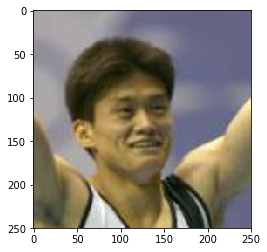


Hello, human 1!
You look like a ...
Basenji


Checking input ...


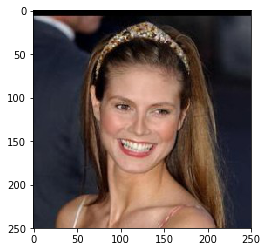


Hello, human 1!
You look like a ...
Yorkshire terrier


Checking input ...


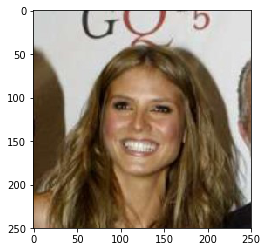


Hello, human 1!
You look like a ...
Basenji


Checking input ...


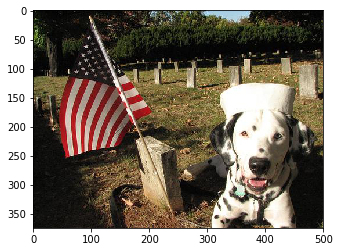


Dog image.
Dalmatian detected.


Checking input ...


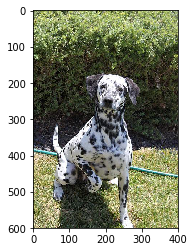


Dog image.
Dalmatian detected.


Checking input ...


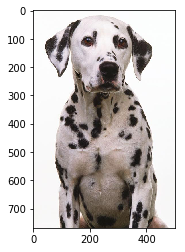


Dog image.
Dalmatian detected.


In [36]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
target_range = 3
h_r = int(np.rint(np.random.uniform(len(human_files) - target_range)))
d_r = int(np.rint(np.random.uniform(len(dog_files) - target_range)))
for file in np.hstack((human_files[h_r:h_r+target_range], dog_files[d_r:d_r+target_range])):
    run_app(file)

<a id='step7'></a>
## Step 7: Flask app

### Start the app

In [37]:
import subprocess
cmd = "FLASK_ENV=development FLASK_APP=app.py flask run"
sps = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
# give the app some time to start
sleep(5)

### Use the app

In [38]:
def parse_response(json_file):
    if json_file['detected_entity'] == 'human':
        message = "\n\tHello, human!"
        message += "\n\tYou look like a ...\n\t{}".format(json_file['dog_class_name'])
        
    elif json_file['detected_entity'] == 'dog':    
        message = "\n\tDog image."
        message += "\n\t{} detected.".format(json_file['dog_class_name'])
        
    else:
        message = '\n\tDid not detected any human or dog in the image!'
        
    return message


Checking input 1:
/data/lfw/Justine_Pasek/Justine_Pasek_0006.jpg


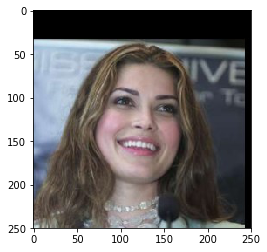

Dog app is unavailable. Retry attempt 1.
Dog app is unavailable. Retry attempt 2.

	Hello, human!
	You look like a ...
	English toy spaniel

Checking input 2:
/data/lfw/Justine_Pasek/Justine_Pasek_0004.jpg


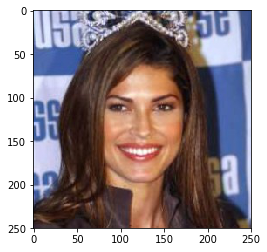


	Hello, human!
	You look like a ...
	Alaskan malamute

Checking input 3:
/data/lfw/Oliver_Stone/Oliver_Stone_0001.jpg


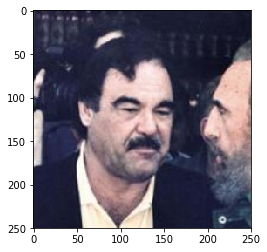


	Hello, human!
	You look like a ...
	Akita

Checking input 4:
/data/dog_images/train/113.Old_english_sheepdog/Old_english_sheepdog_07383.jpg


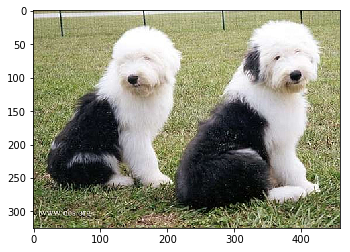


	Dog image.
	Old english sheepdog detected.

Checking input 5:
/data/dog_images/train/113.Old_english_sheepdog/Old_english_sheepdog_07352.jpg


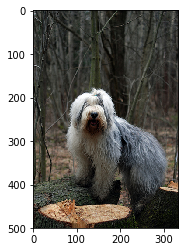


	Dog image.
	Old english sheepdog detected.

Checking input 6:
/data/dog_images/train/113.Old_english_sheepdog/Old_english_sheepdog_07363.jpg


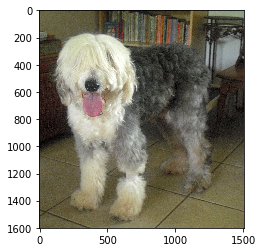


	Dog image.
	Old english sheepdog detected.


In [39]:
import requests
retries = 5

sample_range = 3
h_r = int(np.rint(np.random.uniform(len(human_files) - sample_range)))
d_r = int(np.rint(np.random.uniform(len(dog_files) - sample_range)))
for n, file in enumerate(np.hstack((human_files[h_r:h_r+sample_range], dog_files[d_r:d_r+sample_range]))):
    print("\nChecking input {}:\n{}".format(n+1, file))
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    
    for i in range(retries):
        response = None
        try:
            response = requests.post("http://localhost:5000/predict",
                                     files={"file": open(file,'rb')})
        except Exception as e:
            pass
        
        if response is not None and response.ok:
            print(parse_response(response.json()))
            break
        else:
            if i+1 == retries:
                print('Dog app is unavailable. Request canceled.')
            else:
                print('Dog app is unavailable. Retry attempt {}.'.format(i+1))
                sleep(1)

### Stop the app

In [40]:
!pgrep -f flask | xargs kill -9